# Necessary installs

In [1]:
! pip install yahooquery --upgrade
! pip install urllib3 --upgrade
! pip install requests-futures --upgrade
! pip install requests --upgrade
# ! pip install backtesting --upgrade
# ! pip install backtrader --upgrade
! pip install pandas_ta
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.15
    Uninstalling urllib3-1.26.15:
      Successfully uninstalled urllib3-1.26.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.27.1 requires urllib3<1.27,>=1.21.1, but you have urllib3 2.0.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: ur

# Necessary imports

In [2]:
from yahooquery import Ticker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas_ta as ta
import tensorflow as tf

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:
# from backtesting import Strategy
# from backtesting import Backtest

# # import backtrader as bt
# # import datetime

# Functions

## Get data

In [4]:
def get_data(script: str, period: str="5y", interval: str ="1d", start=None, end=None):
    t = Ticker(script, asynchronous=True)
    df = t.history(period=period, interval=interval, start=start, end=end)
        
    df = df.reset_index(level=0)
#     df = df.drop("symbol", axis=1)
    df.index = pd.to_datetime(df.index)
    
    
    df["close_log"] = np.log(df["close"] / df["close"].shift(1))
    # df["adjclose_log"] = np.log(df["adjclose"] / df["adjclose"].shift(1))

    df.columns = df.columns.str.capitalize()
    df = df.fillna(0)
    
    return df

## Plot lines

In [5]:
def plot_lines(df_list:list, source="Close"):  
    fig = go.Figure()
    for k in df_list:
        fig.add_trace(go.Scatter(x=k.index,
                                 y=k[source],
                                 mode="lines",
                                 name=k["Symbol"][0]
                                )
                     )
    fig.show()

## Add indicators to dataframe

In [6]:
def add_ta_indicators(df, 
                      sma_length=15, 
                      willr_length=14,
                      rsi_length=14,
                      macd_fast=12, macd_slow=26, macd_signal=9,
                      stoch_k=14, stoch_d=3, 
                      supertrend_length=14, supertrend_multiplier=3):

    df.ta.sma(length=sma_length, append=True)
    df.ta.willr(length=willr_length, append=True)
    df.ta.rsi(length=rsi_length, append=True)
    df.ta.macd(fast=macd_fast, slow=macd_slow, signal=macd_signal, append=True)
    df.ta.stoch(length=stoch_k, append=True)
    # df.ta.supertrend(length=supertrend_length, multiplier=supertrend_multiplier, append=True)
    
    return df


## Weight matrix initialization using Moore-Penrose principle:


In [7]:
def generalized_inverse(M, Y, a=0.02):
    """Computes the Moore-Penrose generalized inverse of matrix M using regularization."""
    MtM = tf.matmul(tf.transpose(M), M)
    identity = tf.eye(MtM.shape[0], dtype=MtM.dtype)
    reg_term = tf.keras.regularizers.L2(a)(identity) * identity
    MtM_reg = MtM + reg_term
    w = tf.matmul(tf.linalg.inv(MtM_reg), tf.transpose(M))
    w = tf.matmul(w, Y)
    return w

## Neural network (Computationally Efficient Functional Link Artificial Neural Network)

In [8]:
class CEFLANN(tf.keras.layers.Layer):
  def __init__(self, units, n, reg_param=0.01, activation='tanh',**kwargs):
    super().__init__(**kwargs)
    self.n = n
    self.units = units
    self.rg = reg_param
    self.activation = tf.keras.activations.get(activation)


  def build(self, input_shape):
    self.input_dim = input_shape[-1]
    self.output_dim = self.input_dim + self.n

    self.wl = []
    for i in range(1, self.n+1):
      w = self.add_weight(
          name=f"kernel_{i}",
          initializer="random_normal",
          shape=[self.input_dim, self.units]
      )
      self.wl.append(w)

    self.en_weights = self.add_weight(
        name="kernel",
        initializer="random_normal",
        shape=[self.output_dim, self.units]
    )
    super(CEFLANN, self).build(input_shape)
  

  def call(self, X):

    cx = []
    for w in self.wl:
      oi = tf.math.tanh( ( tf.reduce_sum(tf.matmul(X, w)) )  )
      cx.append(oi)

    cx = tf.tile(tf.reshape(cx, (1, len(cx))), [tf.shape(X)[0], 1])
    exp_patterns = tf.concat([X, cx], axis=1)
    m = exp_patterns

    y = tf.matmul(m, self.en_weights)

    w = generalized_inverse(m, y, a=self.rg)


    ## default output
    # final_out = (tf.matmul(m, w))


    ## only when activation is really necessary:

    final_out = self.activation(tf.matmul(m, w))
    if self.activation == tf.keras.activations.get("tanh"):
      f_out = (final_out + 1.0) / 2.0
      return f_out
    else:
      return final_out

    return final_out


## Plot results (Signals predicted by neural nets)

In [9]:
# # THIS USES PLOTLY FOR PLOTTING.

# def predict_plot(data, train, test, ptype: str="line", sensitivity:float = 0.5):
#   """sensitivity: range is 0 to 1. i.e [0,1]. Lesser sensitivity leads to more active trades and likely more false signals.
#   ptype: 'line'- plots closing price line | 'candle'- plots candlestick graph.
#   """
#   ptype = ptype.lower()
#   data = data[len(train):]

#   fig = go.Figure()


#   y_preds = model.predict(test)
#   otr = [y[0] for y in y_preds]
#   print(list(otr), "\n")
#   signal = []
#   for i in otr:
#     if i < sensitivity:
#       signal.append("up") 
#     else:
#       signal.append("down")
      
#   action = []
#   prev_signal = "down"
#   for s in signal:
#       if s == "up" and prev_signal == "down":
#           action.append(1)
#           prev_signal = "up"
#       elif s == "down" and prev_signal == "up":
#           action.append(-1)
#           prev_signal = "down"
#       else:
#           action.append(0)

#   pa = pd.DataFrame({"trend": signal,
#                     "action": action,
#                      "close": data.Close
#                     }, 
#                     index=data.index)
  
#   # initialize variables
#   buy_price = None
#   sell_price = None
#   profits = []
#   # pl = []


#   print("====================== PROFIT PERCENTAGES PER BUY_SELL ITERATION ============================")
#   # iterate through actions
#   for i, action in enumerate(action):
#       # buy action
#       if action == 1:
#           buy_price = pa.iloc[i]["close"]
#       # sell action
#       elif action == -1:
#           sell_price = pa.iloc[i]["close"]
#           # calculate profit percent and append to list
#           profit_percent = (sell_price - buy_price) / buy_price * 100

          
#           print(profit_percent)


#           # plnet = (sell_price - buy_price)
#           profits.append(profit_percent)
#           # pl.append(plnet)

#           # reset variables
#           buy_price = None
#           sell_price = None
#   print("=======================================================================")
#   print("")
#   print("=======================================================================")
#   print(f"Net profit percent: {round(sum(profits), 2)} %")
#   # print(f"Net profit: {round(sum(pl), 2)} Rupees!")
#   print(f'Invested: { round(np.sum(pa["close"][pa["action"] == 1]), 2) } Rupees!' )
#   print("=======================================================================")


#   if ptype == "line":
#     fig.add_trace(go.Scatter(
#         y=data.Close, x=data.index,
#         line_color="blue"
#         ))
    
#   elif ptype == "candle":
#     fig = go.Figure(data=[go.Candlestick(x=data.index,
#                                         open=data.Open,
#                                         high=data.High,
#                                         low=data.Low,
#                                         close=data.Close)])


#   buyR = pa["action"][pa["action"] == 1]
#   sellR = pa["action"][pa["action"] == -1]

#   fig.add_trace(go.Scatter(
#       x=buyR.index, y=data.Close[buyR.index],
#       mode="markers",
#       marker_color="green",
#       name="buy",
#       marker_symbol="triangle-up",
#       marker_size=8
#   ))
#   fig.add_trace(go.Scatter(
#       x=sellR.index, y=data.Close[sellR.index],
#       mode="markers",
#       marker_color="red",
#       name="sell",
#       marker_symbol="triangle-down",
#       marker_size=8
#   ))

#   fig.show()

In [10]:
## SAME AS ABOVE HOWEVER IT USES SEABORN FOR PLOTTING BUT HMM IS INCLUDED.

import seaborn as sns
import matplotlib.pyplot as plt

def predict_plot_with_hmm(data, train, test, model, state_, sensitivity:float = 0.5):
    """sensitivity: range is 0 to 1. i.e [0,1]. Lesser sensitivity leads to more active trades and likely more false signals.
    """
    print("++++++++++++++++++++ TRADES USING HIDDEN MARKOV MODEL +++++++++++++++++++++++++++++++++")
    data = data[len(train):]

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.grid(True, linestyle='--', which='both')
    ax.set_facecolor('#F0F0F0')
    # ax.set_facecolor('#222222')

    regime_detection = RegimeDetection()
    params = {'n_components':2, 'covariance_type':"full", 'random_state':100}

    prices_array = np.asarray(data.Close).reshape(-1, 1)
    
    hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
    hmm_states = hmm_model.predict(prices_array)

    y_preds = model.predict(test)
    otr = [y[0] for y in y_preds]
    print(list(otr), "\n")
    signal = []
    for i in otr:
        if i < sensitivity:
            signal.append("up") 
        else:
            signal.append("down")

    action = []
    prev_signal = "down"
    for s, state in zip(signal, hmm_states):
        if state == state_:
            if s == "up" and prev_signal == "down":
                action.append(1)
                prev_signal = "up"
            elif s == "down" and prev_signal == "up":
                action.append(-1)
                prev_signal = "down"
            else:
                action.append(0)
        else:
            action.append(0)

    pa = pd.DataFrame({"trend": signal,
                        "action": action,
                        "close": data.Close,
                        }, 
                        index=data.index)

    # initialize variables
    buy_price = None
    sell_price = None
    profits = []

    print("====================== PROFIT PERCENTAGES PER BUY_SELL ITERATION ============================")
    # iterate through actions
    for i, action in enumerate(action):
        # buy action
        if action == 1:
            buy_price = pa.iloc[i]["close"]
        # sell action
        elif action == -1:
            sell_price = pa.iloc[i]["close"]
            # calculate profit percent and append to list
            profit_percent = (sell_price - buy_price) / buy_price * 100

            print(profit_percent)

            profits.append(profit_percent)

            # reset variables
            buy_price = None
            sell_price = None
    print("=======================================================================")
    print("")
    print("=======================================================================")
    print(f"Net profit percent: {round(sum(profits), 2)} %")
    print(f'Invested: { round(np.sum(pa["close"][pa["action"] == 1]), 2) } Rupees!' )
    print("=======================================================================")


    sns.lineplot(x=data.index, y=data.Close, ax=ax)

    buyR = pa["action"][pa["action"] == 1]
    sellR = pa["action"][pa["action"] == -1]
    

    ax.scatter(buyR.index, data.Close[buyR.index], color="green", marker="^", s=50, label="Buy")
    ax.scatter(sellR.index, data.Close[sellR.index], color="red", marker="v", s=50, label="Sell")

    ax.set_xlabel("Date")
    ax.set_ylabel("Price")



    plt.legend()
    plt.show()


In [11]:
## SAME AS ABOVE HOWEVER IT USES SEABORN FOR PLOTTING HOWEVER HMM IS NOT INCLUDED IN HERE.

import seaborn as sns
import matplotlib.pyplot as plt

def predict_plot(data, train, test, model, sensitivity:float = 0.5, ):
    """sensitivity: range is 0 to 1. i.e [0,1]. Lesser sensitivity leads to more active trades and likely more false signals.
    """
    data = data[len(train):]

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.grid(True, linestyle='--', which='both')
    ax.set_facecolor('#F0F0F0')
    # ax.set_facecolor('#222222')



    y_preds = model.predict(test)
    otr = [y[0] for y in y_preds]
    print(list(otr), "\n")
    signal = []
    for i in otr:
        if i < sensitivity:
            signal.append("up") 
        else:
            signal.append("down")

    action = []
    prev_signal = "down"
    for s in signal:
        if s == "up" and prev_signal == "down":
            action.append(1)
            prev_signal = "up"
        elif s == "down" and prev_signal == "up":
            action.append(-1)
            prev_signal = "down"
        else:
            action.append(0)

    pa = pd.DataFrame({"trend": signal,
                        "action": action,
                        "close": data.Close,
                        }, 
                        index=data.index)

    # initialize variables
    buy_price = None
    sell_price = None
    profits = []

    print("====================== PROFIT PERCENTAGES PER BUY_SELL ITERATION ============================")
    # iterate through actions
    for i, action in enumerate(action):
        # buy action
        if action == 1:
            buy_price = pa.iloc[i]["close"]
        # sell action
        elif action == -1:
            sell_price = pa.iloc[i]["close"]
            # calculate profit percent and append to list
            profit_percent = (sell_price - buy_price) / buy_price * 100

            print(profit_percent)

            profits.append(profit_percent)

            # reset variables
            buy_price = None
            sell_price = None
    print("=======================================================================")
    print("")
    print("=======================================================================")
    print(f"Net profit percent: {round(sum(profits), 2)} %")
    print(f'Invested: { round(np.sum(pa["close"][pa["action"] == 1]), 2) } Rupees!' )
    print("=======================================================================")


    sns.lineplot(x=data.index, y=data.Close, ax=ax)

    buyR = pa["action"][pa["action"] == 1]
    sellR = pa["action"][pa["action"] == -1]
    

    ax.scatter(buyR.index, data.Close[buyR.index], color="green", marker="^", s=50, label="Buy")
    ax.scatter(sellR.index, data.Close[sellR.index], color="red", marker="v", s=50, label="Sell")

    ax.set_xlabel("Date")
    ax.set_ylabel("Price")



    plt.legend()
    plt.show()


# Operations 

## Calculate trend of the market (5 days rolling)

In [12]:
def add_trend(df):
  # check if closing price is greater than moving average
  mask1 = df['Close'] > df['SMA_15']
  mask2 = df['Close'] < df['SMA_15']

  # check if moving average is increasing over the last 5 days
  mask3 = df['SMA_15'].rolling(5).apply(lambda x: np.all(np.diff(x) > 0))

  # check if moving average is decreasing over the last 5 days
  mask4 = df['SMA_15'].rolling(5).apply(lambda x: np.all(np.diff(x) < 0))

  # combine masks and assign trend signal
  df['trend'] = np.where(mask1 & mask3, "up", np.where(mask2 & mask4, "down", "none"))

  df = df.dropna()
  return df

## Calculate signal strength (between 0 to 1)

In [13]:
def add_signal_strength(df):
  con1 = df["trend"] == "up"
  con2 = df["trend"] == "down"

  max_cp = df['Close'].rolling(window=3, min_periods=1).max().shift(-2)
  min_cp = df['Close'].rolling(window=3, min_periods=1).min().shift(-2)

  up = (df["Close"] - min_cp) / (max_cp - min_cp) * 0.5 + 0.5 
  down = (df["Close"] - min_cp) / (max_cp - min_cp) * 0.5 

  df["signal"] = np.where(con1, up, np.where(con2, down, 0))

  df = df.fillna(0)
  return df

## Data normalization (Min-Max Normalization)

In [14]:
def normalize_split_data(df):
  ndf = df[[ 'SMA_15', 'WILLR_14', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3',
       'STOCHd_14_3_3' ]]

  scaler = MinMaxScaler()
  data = scaler.fit_transform(ndf)
  data = pd.DataFrame(data, columns=ndf.columns)

  X = data
  y = df["signal"]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
  return X_train, X_test, y_train, y_test


# Build and compile network

In [15]:
### No. of hidden layers, No. of neurons in hidden layers, activation function (sigmoid, tanh only), Training epochs, No. of n.
### These parameters affect results for better or worse. Comes to trial/error or optimization (Optuna, kerasTuner etc.)

## There is no backpropogation for efficiency
def train_model(X_train, y_train, epochs=100, batch_size=32, n=60, units=1, activation="sigmoid", reg_val=0.001):
  model = tf.keras.Sequential([
    CEFLANN(n=n, units=units, reg_param=reg_val, activation=activation, input_shape=( X_train.shape[-1] , )),
    ])


  model.compile(loss='mse')

  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
  return model

## Testing code

# Markov Model experiment

A hidden markov model is able to predict the regime of the next candle based on previous candles.
We are going to use that to cancel out false signals (trades) to reduce our risk/losses.



In [16]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 7.7 MB/s eta 0:00:00


In [17]:
from hmmlearn.hmm import GaussianHMM

class RegimeDetection:
 
    def get_regimes_hmm(self, input_data, params):
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model
        
    def initialise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model

In [18]:
def plot_hidden_states(hidden_states, prices_df):
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices
    
    Output:
    Graph showing hidden states and prices
    
    '''
    
    colors = ['blue', 'green', "red", "yellow", "black"]
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
 
    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i,":", len(prices_df.index[mask]))
        
        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df["Close"][mask],
                    mode='markers',  name='Hidden State ' + str(i), marker=dict(size=4,color=colors[i])))
        
    fig.update_layout(legend=dict(
            yanchor="top", y=0.99, xanchor="left",x=0.01), margin=dict(l=20, r=20, t=20, b=20)).show()

In [19]:
def plot_regimes(df, states=2):
  regime_detection = RegimeDetection()

  params = {'n_components':states, 'covariance_type':"full", 'random_state':100}
  
  prices_array = np.array(df.Close[len(X_train):]).reshape(-1,1)

  hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
  hmm_states = hmm_model.predict(prices_array)
  covars = hmm_model.covars_
  print("Covariance matrix: ", list(covars))
  min_cov_state = np.argmin(covars)
  print("State with minimim covariance: ", min_cov_state)


  plot_hidden_states(np.array(hmm_states), df[len(X_train):])

# Advance stuff for backtesting

In [ ]:


# class NN(Strategy):
  


#   def init(self):

#     self.x = self.data.df[[ 'SMA_15', 'WILLR_14', 'RSI_14',
#        'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3',
#        'STOCHd_14_3_3' ]]

#     scaler = MinMaxScaler()
#     data = scaler.fit_transform(self.x)
#     self.x = pd.DataFrame(data, columns=self.x.columns)

#     self.X = self.x
#     self.y = self.data.df["signal"]

#     X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, shuffle=False)


#     self.m = tf.keras.Sequential([
#         CEFLANN(n=15, units=1, reg_param=0.001, activation='sigmoid', input_shape=( X_train.shape[-1], )),  
#     ])

#     self.m.compile(loss='mse')
#     self.m.fit(X_train, y_train, epochs=25, batch_size=32)

#     self.preds = self.m.predict(self.X)
#     self.p = [y[0] for y in self.preds]

#     self.trend = ["up" if i < 0.5 else "down" for i in self.p]

#     self.action = []
#     prev_signal = "down"
#     for s in self.trend:
#         if s == "up" and prev_signal == "down":
#             self.action.append("buy")
#             prev_signal = "up"
#         elif s == "down" and prev_signal == "up":
#             self.action.append("sell")
#             prev_signal = "down"
#         else:
#             self.action.append("")

#     self.data.df["action"] = self.action
#   def next(self):
#     if self.data["action"] == "buy":
#       self.buy()
#       # print(self.data.Close[-1], "Buy")
#     elif self.data["action"] == "sell":
#       self.position.close()
#       self.sell(tp=self.data.Close[-1]*0.5)
#       # print(self.data.Close[-1], "Sell")
#       # print("")

In [ ]:
# bt = Backtest(df, NN, cash=50_000, commission=.003)
# stats = bt.run()
# stats

In [ ]:
# bt.plot()

# Experiments and Results

### Bajaj finance
Volatile for quiet a few years.

In [ ]:
bajaj_finance = get_data("BAJFINANCE.NS")
bajaj_finance = add_ta_indicators(bajaj_finance, 
                                  sma_length=15, 
                                  willr_length=14,
                                  rsi_length=14,
                                  macd_fast=12, macd_slow=26, macd_signal=9,
                                  stoch_k=14, stoch_d=3, 
                                  supertrend_length=14, supertrend_multiplier=3)
bajaj_finance = add_trend(bajaj_finance)
bajaj_finance = add_signal_strength(bajaj_finance)
X_train, X_test, y_train, y_test = normalize_split_data(bajaj_finance)

model = train_model(X_train, y_train)

<ipython-input-34-30c7597758ee>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/100
27/27 [==============================] - 13s 18ms/step - loss: 0.1521
Epoch 2/100
27/27 [==============================] - 0s 15ms/step - loss: 0.1472
Epoch 3/100
27/27 [==============================] - 0s 11ms/step - loss: 0.1449
Epoch 4/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1426
Epoch 5/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1413
Epoch 6/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1396
Epoch 7/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1371
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1359
Epoch 9/100
27/27 [==============================] - 0s 11ms/step - loss: 0.1337
Epoch 10/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1321
Epoch 11/100
27/27 [==============================] - 0s 17ms/step - loss: 0.1307
Epoch 12/100
27/27 [==============================] - 0s 17ms/step - loss: 0.1295
Epoch 13/100
27/27 [====

12/12 [==============================] - 1s 6ms/step
[0.07862735, 0.0900824, 0.102047525, 0.123963, 0.17447555, 0.17275538, 0.15382487, 0.1787299, 0.26132157, 0.39915645, 0.5191955, 0.46550238, 0.37371057, 0.2161549, 0.2167359, 0.124140136, 0.10674096, 0.079576984, 0.10262241, 0.13642778, 0.15183008, 0.17867084, 0.191178, 0.20128688, 0.19390726, 0.28466555, 0.43377432, 0.54562706, 0.6483755, 0.68785423, 0.6718989, 0.68610865, 0.673541, 0.68723094, 0.69605035, 0.708934, 0.7113558, 0.6596007, 0.53978765, 0.44400176, 0.2570149, 0.15335006, 0.118758574, 0.09077026, 0.08646995, 0.09918166, 0.10668403, 0.15496112, 0.14956988, 0.17055371, 0.12887806, 0.14023738, 0.16778876, 0.21457343, 0.2227906, 0.1505028, 0.28554034, 0.2639157, 0.32735735, 0.29922488, 0.2850221, 0.267166, 0.29436657, 0.14559977, 0.2405483, 0.24897249, 0.22271338, 0.17992383, 0.113371864, 0.074750185, 0.073140346, 0.11520711, 0.16821368, 0.22771381, 0.27700388, 0.30352598, 0.40196618, 0.49790597, 0.51089025, 0.5784437, 0.587

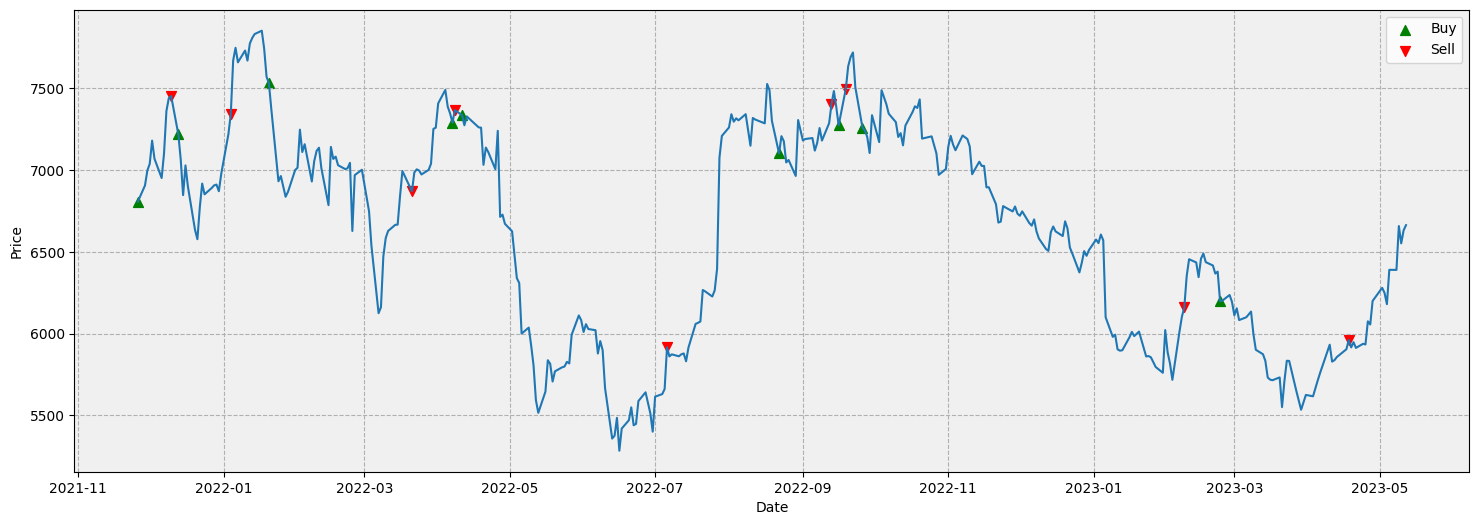

In [ ]:
predict_plot(data=bajaj_finance, test=X_test, train=X_train, model=model, sensitivity=0.5)

In [ ]:
plot_regimes(bajaj_finance, states=2)

Covariance matrix:  [[[ 33652.58460822]]

 [[287305.51576341]]]
State with minimim covariance:  0
Number of observations for State  0 : 160
Number of observations for State  1 : 201


12/12 [==============================] - 0s 5ms/step
[0.32069737, 0.26349083, 0.19268844, 0.21375166, 0.22200775, 0.2376784, 0.21302418, 0.23637573, 0.2554786, 0.2765541, 0.29287964, 0.3213624, 0.3303691, 0.346155, 0.29925802, 0.21870995, 0.18534414, 0.17653544, 0.21802512, 0.24118541, 0.25606218, 0.26501876, 0.30316895, 0.29959163, 0.29946947, 0.33717307, 0.37909397, 0.4647966, 0.48736465, 0.5655915, 0.56727606, 0.59955055, 0.60282755, 0.6366483, 0.66146064, 0.65475315, 0.6839792, 0.58414114, 0.6520191, 0.6376445, 0.5825711, 0.41063735, 0.4302599, 0.4073415, 0.46436453, 0.5114621, 0.5552114, 0.5831166, 0.61887395, 0.63746965, 0.6230156, 0.4332023, 0.38787755, 0.35393912, 0.26752752, 0.19527848, 0.2135216, 0.21384439, 0.20678273, 0.19336578, 0.1800124, 0.15906826, 0.14346983, 0.1102423, 0.15115428, 0.19080733, 0.24755538, 0.30156392, 0.30885798, 0.2720013, 0.348202, 0.4108684, 0.4888774, 0.5434781, 0.55586165, 0.51734537, 0.5303983, 0.52925485, 0.47909436, 0.50899, 0.5299941, 0.5852126

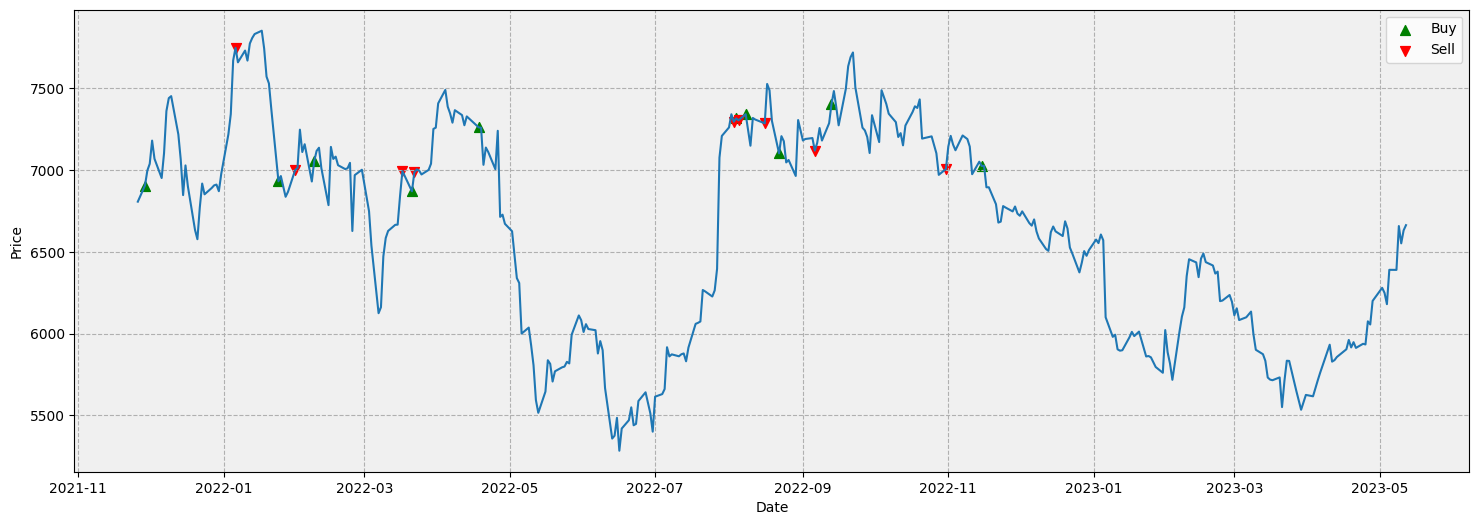

In [ ]:
predict_plot_with_hmm(data=bajaj_finance, test=X_test, train=X_train, state_=0, model=model, sensitivity=0.5)

## DIVISLAB
Had a sudden regime change this year.

In [ ]:
dl = get_data("DIVISLAB.NS")
dl = add_ta_indicators(dl, 
                      sma_length=15, 
                      willr_length=14,
                      rsi_length=14,
                      macd_fast=12, macd_slow=26, macd_signal=9,
                      stoch_k=14, stoch_d=3, 
                      supertrend_length=14, supertrend_multiplier=3)

dl = add_trend(dl)
dl = add_signal_strength(dl)
X_train, X_test, y_train, y_test = normalize_split_data(dl)

model = train_model(X_train, y_train)

<ipython-input-34-30c7597758ee>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/100
27/27 [==============================] - 9s 10ms/step - loss: 0.1495
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1457
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1448
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1421
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1404
Epoch 6/100
27/27 [==============================] - 0s 11ms/step - loss: 0.1389
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1373
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1357
Epoch 9/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1354
Epoch 10/100
27/27 [==============================] - 0s 9ms/step - loss: 0.1335
Epoch 11/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1319
Epoch 12/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1310
Epoch 13/100
27/27 [======

12/12 [==============================] - 0s 5ms/step
[0.15384251, 0.21012793, 0.2474956, 0.17472231, 0.15923356, 0.122695096, 0.076531604, 0.062479176, 0.050281268, 0.05107139, 0.043821037, 0.04702372, 0.06880946, 0.067012824, 0.08067619, 0.060722005, 0.05665787, 0.05148463, 0.09701539, 0.092490494, 0.108749904, 0.12144328, 0.167306, 0.29475322, 0.39365953, 0.51871794, 0.51633877, 0.48879203, 0.3782833, 0.25614184, 0.21947922, 0.14316992, 0.14436448, 0.11488517, 0.18445732, 0.2394073, 0.32317737, 0.23322324, 0.16562478, 0.08975353, 0.06126237, 0.061595224, 0.06303865, 0.05562181, 0.052270718, 0.062489096, 0.079858065, 0.1213828, 0.1643191, 0.21600656, 0.20498513, 0.26188913, 0.32397565, 0.41385972, 0.40678295, 0.38767114, 0.39946857, 0.5010654, 0.51223844, 0.45328784, 0.2947171, 0.19321851, 0.11652366, 0.06725084, 0.0994815, 0.15470041, 0.16207261, 0.18074523, 0.14823414, 0.12883751, 0.14693715, 0.18566708, 0.28369543, 0.4393627, 0.55219644, 0.5722972, 0.59422326, 0.6405052, 0.6074708,

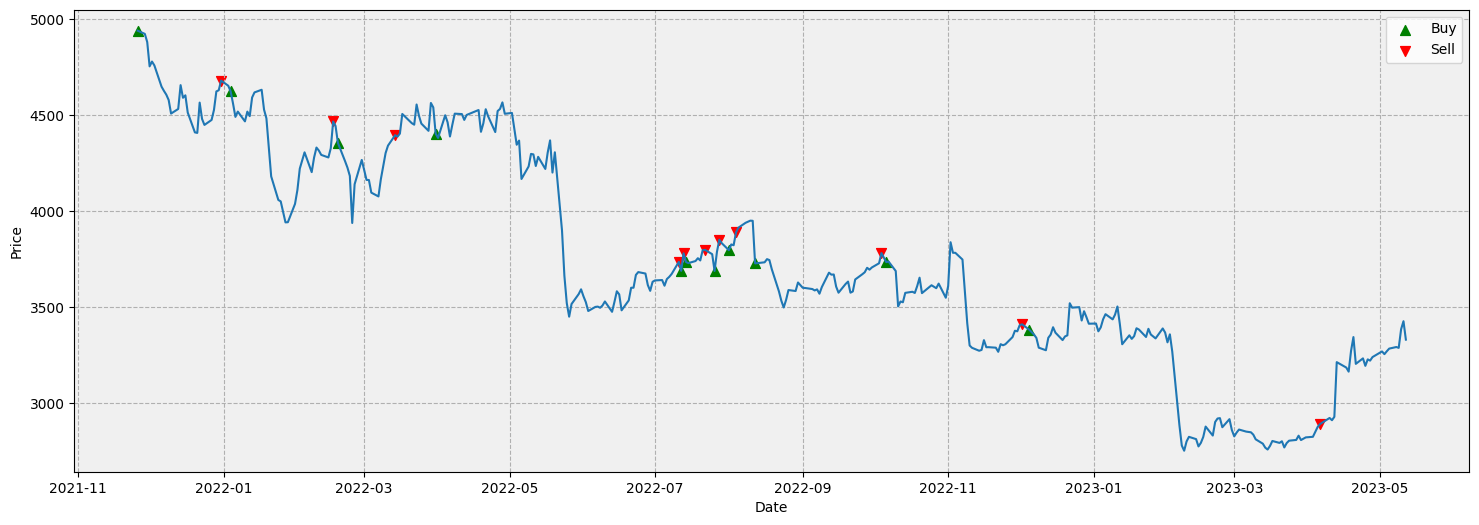

In [ ]:
predict_plot(data=dl, test=X_test, train=X_train, model=model, sensitivity=0.5)

In [ ]:
plot_regimes(dl, states=2)

Covariance matrix:  [[[38087.90947336]]

 [[99106.4951038 ]]]
State with minimim covariance:  0
Number of observations for State  0 : 120
Number of observations for State  1 : 241


12/12 [==============================] - 0s 7ms/step
[0.32069737, 0.26349083, 0.19268844, 0.21375166, 0.22200775, 0.2376784, 0.21302418, 0.23637573, 0.2554786, 0.2765541, 0.29287964, 0.3213624, 0.3303691, 0.346155, 0.29925802, 0.21870995, 0.18534414, 0.17653544, 0.21802512, 0.24118541, 0.25606218, 0.26501876, 0.30316895, 0.29959163, 0.29946947, 0.33717307, 0.37909397, 0.4647966, 0.48736465, 0.5655915, 0.56727606, 0.59955055, 0.60282755, 0.6366483, 0.66146064, 0.65475315, 0.6839792, 0.58414114, 0.6520191, 0.6376445, 0.5825711, 0.41063735, 0.4302599, 0.4073415, 0.46436453, 0.5114621, 0.5552114, 0.5831166, 0.61887395, 0.63746965, 0.6230156, 0.4332023, 0.38787755, 0.35393912, 0.26752752, 0.19527848, 0.2135216, 0.21384439, 0.20678273, 0.19336578, 0.1800124, 0.15906826, 0.14346983, 0.1102423, 0.15115428, 0.19080733, 0.24755538, 0.30156392, 0.30885798, 0.2720013, 0.348202, 0.4108684, 0.4888774, 0.5434781, 0.55586165, 0.51734537, 0.5303983, 0.52925485, 0.47909436, 0.50899, 0.5299941, 0.5852126

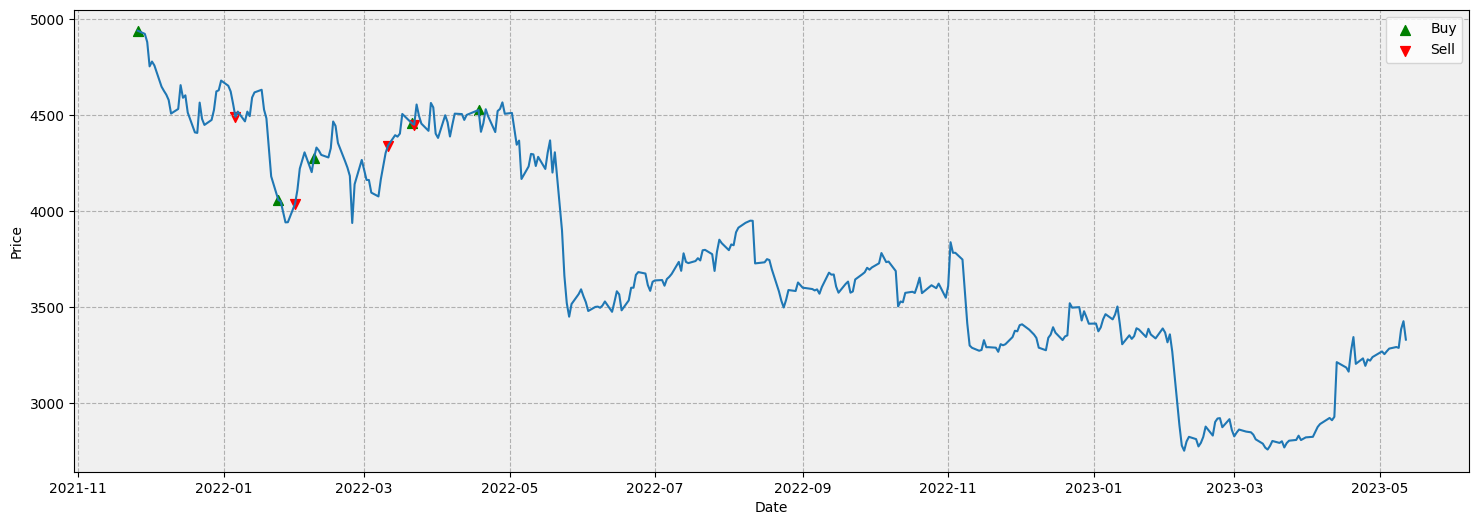

In [ ]:
predict_plot_with_hmm(data=dl, test=X_test, train=X_train, state_=0, model=model, sensitivity=0.5)

## COALINDIA
Test on an steady trending stock

In [ ]:
cl = get_data("COALINDIA.NS")
cl = add_ta_indicators(cl, 
                      sma_length=15, 
                      willr_length=14,
                      rsi_length=14,
                      macd_fast=12, macd_slow=26, macd_signal=9,
                      stoch_k=14, stoch_d=3, 
                      supertrend_length=14, supertrend_multiplier=3)

cl = add_trend(cl)
cl = add_signal_strength(cl)
X_train, X_test, y_train, y_test = normalize_split_data(cl)

model = train_model(X_train, y_train)

<ipython-input-34-30c7597758ee>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/100
27/27 [==============================] - 9s 14ms/step - loss: 0.1276
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 0.1148
Epoch 3/100
27/27 [==============================] - 0s 17ms/step - loss: 0.1148
Epoch 4/100
27/27 [==============================] - 1s 21ms/step - loss: 0.1137
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 0.1127
Epoch 6/100
27/27 [==============================] - 1s 20ms/step - loss: 0.1118
Epoch 7/100
27/27 [==============================] - 1s 21ms/step - loss: 0.1107
Epoch 8/100
27/27 [==============================] - 0s 14ms/step - loss: 0.1101
Epoch 9/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1089
Epoch 10/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1080
Epoch 11/100
27/27 [==============================] - 0s 9ms/step - loss: 0.1079
Epoch 12/100
27/27 [==============================] - 0s 11ms/step - loss: 0.1063
Epoch 13/100
27/27 [======

12/12 [==============================] - 0s 6ms/step
[0.32069737, 0.26349083, 0.19268844, 0.21375166, 0.22200775, 0.2376784, 0.21302418, 0.23637573, 0.2554786, 0.2765541, 0.29287964, 0.3213624, 0.3303691, 0.346155, 0.29925802, 0.21870995, 0.18534414, 0.17653544, 0.21802512, 0.24118541, 0.25606218, 0.26501876, 0.30316895, 0.29959163, 0.29946947, 0.33717307, 0.37909397, 0.4647966, 0.48736465, 0.5655915, 0.56727606, 0.59955055, 0.60282755, 0.6366483, 0.66146064, 0.65475315, 0.6839792, 0.58414114, 0.6520191, 0.6376445, 0.5825711, 0.41063735, 0.4302599, 0.4073415, 0.46436453, 0.5114621, 0.5552114, 0.5831166, 0.61887395, 0.63746965, 0.6230156, 0.4332023, 0.38787755, 0.35393912, 0.26752752, 0.19527848, 0.2135216, 0.21384439, 0.20678273, 0.19336578, 0.1800124, 0.15906826, 0.14346983, 0.1102423, 0.15115428, 0.19080733, 0.24755538, 0.30156392, 0.30885798, 0.2720013, 0.348202, 0.4108684, 0.4888774, 0.5434781, 0.55586165, 0.51734537, 0.5303983, 0.52925485, 0.47909436, 0.50899, 0.5299941, 0.5852126

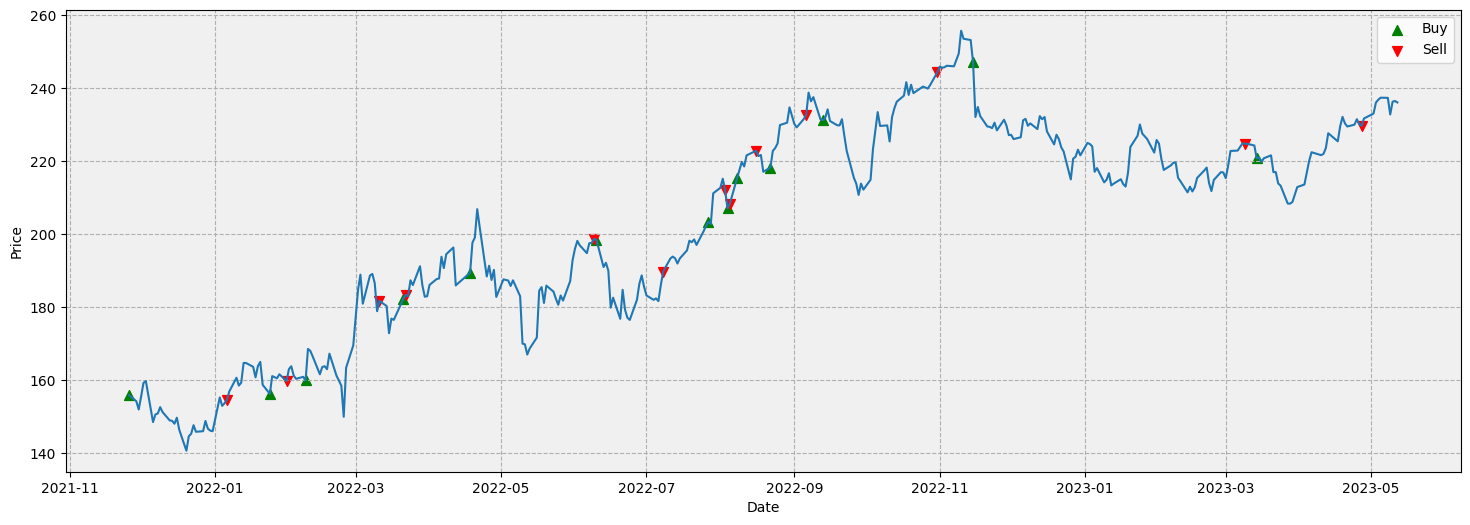

In [ ]:
predict_plot(data=cl, test=X_test, train=X_train, model=model, sensitivity=0.5)

In [ ]:
plot_regimes(cl, states=2)

Covariance matrix:  [[[ 51.12208837]]

 [[415.14537312]]]
State with minimim covariance:  0
Number of observations for State  0 : 66
Number of observations for State  1 : 295


12/12 [==============================] - 0s 5ms/step
[0.32069737, 0.26349083, 0.19268844, 0.21375166, 0.22200775, 0.2376784, 0.21302418, 0.23637573, 0.2554786, 0.2765541, 0.29287964, 0.3213624, 0.3303691, 0.346155, 0.29925802, 0.21870995, 0.18534414, 0.17653544, 0.21802512, 0.24118541, 0.25606218, 0.26501876, 0.30316895, 0.29959163, 0.29946947, 0.33717307, 0.37909397, 0.4647966, 0.48736465, 0.5655915, 0.56727606, 0.59955055, 0.60282755, 0.6366483, 0.66146064, 0.65475315, 0.6839792, 0.58414114, 0.6520191, 0.6376445, 0.5825711, 0.41063735, 0.4302599, 0.4073415, 0.46436453, 0.5114621, 0.5552114, 0.5831166, 0.61887395, 0.63746965, 0.6230156, 0.4332023, 0.38787755, 0.35393912, 0.26752752, 0.19527848, 0.2135216, 0.21384439, 0.20678273, 0.19336578, 0.1800124, 0.15906826, 0.14346983, 0.1102423, 0.15115428, 0.19080733, 0.24755538, 0.30156392, 0.30885798, 0.2720013, 0.348202, 0.4108684, 0.4888774, 0.5434781, 0.55586165, 0.51734537, 0.5303983, 0.52925485, 0.47909436, 0.50899, 0.5299941, 0.5852126

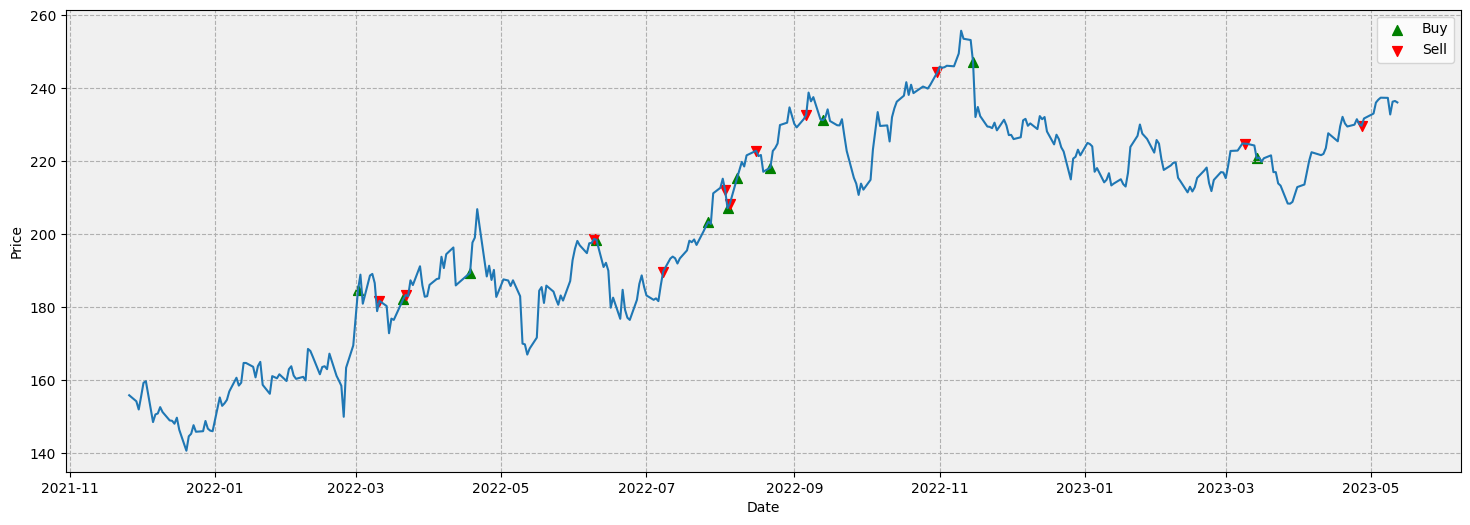

In [ ]:
predict_plot_with_hmm(data=cl, test=X_test, train=X_train, state_=1, model=model, sensitivity=0.5)

##TATAPOWER
Has mixed trends.

In [ ]:
tp = get_data("TATAPOWER.NS")
tp = add_ta_indicators(tp, 
                      sma_length=15, 
                      willr_length=14,
                      rsi_length=14,
                      macd_fast=12, macd_slow=26, macd_signal=9,
                      stoch_k=14, stoch_d=3, 
                      supertrend_length=14, supertrend_multiplier=3)

tp = add_trend(tp)
tp = add_signal_strength(tp)
X_train, X_test, y_train, y_test = normalize_split_data(tp)

model = train_model(X_train, y_train)

<ipython-input-34-30c7597758ee>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/100
27/27 [==============================] - 11s 19ms/step - loss: 0.1371
Epoch 2/100
27/27 [==============================] - 1s 26ms/step - loss: 0.1357
Epoch 3/100
27/27 [==============================] - 1s 27ms/step - loss: 0.1336
Epoch 4/100
27/27 [==============================] - 0s 14ms/step - loss: 0.1323
Epoch 5/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1308
Epoch 6/100
27/27 [==============================] - 0s 13ms/step - loss: 0.1289
Epoch 7/100
27/27 [==============================] - 0s 14ms/step - loss: 0.1280
Epoch 8/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1266
Epoch 9/100
27/27 [==============================] - 0s 17ms/step - loss: 0.1249
Epoch 10/100
27/27 [==============================] - 0s 13ms/step - loss: 0.1242
Epoch 11/100
27/27 [==============================] - 0s 15ms/step - loss: 0.1231
Epoch 12/100
27/27 [==============================] - 1s 20ms/step - loss: 0.1227
Epoch 13/100
27/27 [====

12/12 [==============================] - 1s 4ms/step
[0.32069737, 0.26349083, 0.19268844, 0.21375166, 0.22200775, 0.2376784, 0.21302418, 0.23637573, 0.2554786, 0.2765541, 0.29287964, 0.3213624, 0.3303691, 0.346155, 0.29925802, 0.21870995, 0.18534414, 0.17653544, 0.21802512, 0.24118541, 0.25606218, 0.26501876, 0.30316895, 0.29959163, 0.29946947, 0.33717307, 0.37909397, 0.4647966, 0.48736465, 0.5655915, 0.56727606, 0.59955055, 0.60282755, 0.6366483, 0.66146064, 0.65475315, 0.6839792, 0.58414114, 0.6520191, 0.6376445, 0.5825711, 0.41063735, 0.4302599, 0.4073415, 0.46436453, 0.5114621, 0.5552114, 0.5831166, 0.61887395, 0.63746965, 0.6230156, 0.4332023, 0.38787755, 0.35393912, 0.26752752, 0.19527848, 0.2135216, 0.21384439, 0.20678273, 0.19336578, 0.1800124, 0.15906826, 0.14346983, 0.1102423, 0.15115428, 0.19080733, 0.24755538, 0.30156392, 0.30885798, 0.2720013, 0.348202, 0.4108684, 0.4888774, 0.5434781, 0.55586165, 0.51734537, 0.5303983, 0.52925485, 0.47909436, 0.50899, 0.5299941, 0.5852126

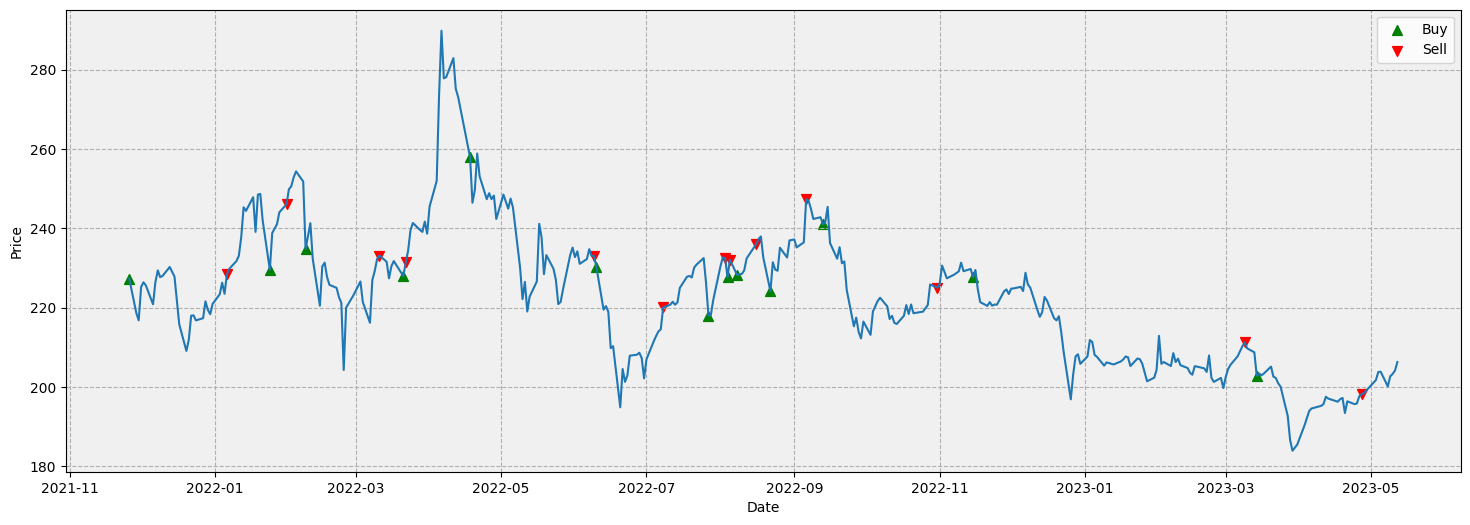

In [ ]:
predict_plot(data=tp, test=X_test, train=X_train, model=model, sensitivity=0.5)

In [ ]:
plot_regimes(tp, states=2)

Number of observations for State  0 : 141
Number of observations for State  1 : 220


12/12 [==============================] - 0s 4ms/step
[0.32069737, 0.26349083, 0.19268844, 0.21375166, 0.22200775, 0.2376784, 0.21302418, 0.23637573, 0.2554786, 0.2765541, 0.29287964, 0.3213624, 0.3303691, 0.346155, 0.29925802, 0.21870995, 0.18534414, 0.17653544, 0.21802512, 0.24118541, 0.25606218, 0.26501876, 0.30316895, 0.29959163, 0.29946947, 0.33717307, 0.37909397, 0.4647966, 0.48736465, 0.5655915, 0.56727606, 0.59955055, 0.60282755, 0.6366483, 0.66146064, 0.65475315, 0.6839792, 0.58414114, 0.6520191, 0.6376445, 0.5825711, 0.41063735, 0.4302599, 0.4073415, 0.46436453, 0.5114621, 0.5552114, 0.5831166, 0.61887395, 0.63746965, 0.6230156, 0.4332023, 0.38787755, 0.35393912, 0.26752752, 0.19527848, 0.2135216, 0.21384439, 0.20678273, 0.19336578, 0.1800124, 0.15906826, 0.14346983, 0.1102423, 0.15115428, 0.19080733, 0.24755538, 0.30156392, 0.30885798, 0.2720013, 0.348202, 0.4108684, 0.4888774, 0.5434781, 0.55586165, 0.51734537, 0.5303983, 0.52925485, 0.47909436, 0.50899, 0.5299941, 0.5852126

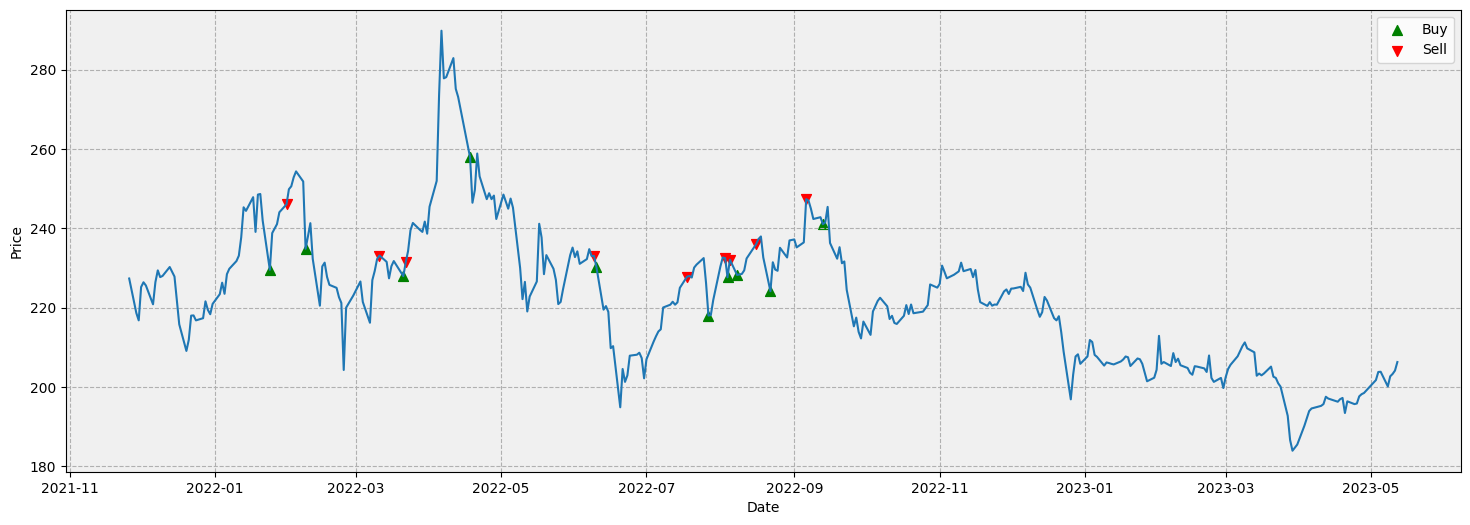

In [ ]:
predict_plot_with_hmm(data=tp, test=X_test, train=X_train, state_=0, model=model, sensitivity=0.5)

##HDFC BANK

In [ ]:
hb = get_data("HDFCBANK.NS")
hb = add_ta_indicators(hb, 
                      sma_length=15, 
                      willr_length=14,
                      rsi_length=14,
                      macd_fast=12, macd_slow=26, macd_signal=9,
                      stoch_k=14, stoch_d=3, 
                      supertrend_length=14, supertrend_multiplier=3)

hb = add_trend(hb)
hb = add_signal_strength(hb)
X_train, X_test, y_train, y_test = normalize_split_data(hb)

model = train_model(X_train, y_train)

<ipython-input-34-30c7597758ee>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/100
27/27 [==============================] - 10s 22ms/step - loss: 0.1410
Epoch 2/100
27/27 [==============================] - 0s 17ms/step - loss: 0.1380
Epoch 3/100
27/27 [==============================] - 0s 13ms/step - loss: 0.1367
Epoch 4/100
27/27 [==============================] - 0s 14ms/step - loss: 0.1343
Epoch 5/100
27/27 [==============================] - 0s 18ms/step - loss: 0.1341
Epoch 6/100
27/27 [==============================] - 0s 18ms/step - loss: 0.1327
Epoch 7/100
27/27 [==============================] - 1s 19ms/step - loss: 0.1317
Epoch 8/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1301
Epoch 9/100
27/27 [==============================] - 1s 22ms/step - loss: 0.1291
Epoch 10/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1283
Epoch 11/100
27/27 [==============================] - 0s 16ms/step - loss: 0.1272
Epoch 12/100
27/27 [==============================] - 0s 15ms/step - loss: 0.1262
Epoch 13/100
27/27 [====

12/12 [==============================] - 0s 4ms/step
[0.05998394, 0.07920914, 0.078370824, 0.10319724, 0.14863682, 0.15717566, 0.1636052, 0.22191046, 0.33860323, 0.3207357, 0.3283871, 0.26379997, 0.21139738, 0.17401208, 0.1568172, 0.09500124, 0.072321914, 0.06773273, 0.06937722, 0.07238384, 0.071871616, 0.08239184, 0.09544127, 0.10238227, 0.12002267, 0.16964205, 0.30738834, 0.40675884, 0.5099195, 0.4777067, 0.49097902, 0.49430797, 0.5344162, 0.51449513, 0.43533555, 0.42543203, 0.3318314, 0.32371643, 0.258095, 0.19417468, 0.1820293, 0.1218353, 0.12851286, 0.1111345, 0.10142567, 0.11919721, 0.13904995, 0.24059759, 0.2612336, 0.33042213, 0.20804971, 0.16792378, 0.19324514, 0.27647457, 0.32971102, 0.24844342, 0.33652037, 0.31705812, 0.32063997, 0.33288494, 0.36958218, 0.3464074, 0.32154074, 0.15976606, 0.15827566, 0.094784535, 0.076749764, 0.061208628, 0.060118165, 0.052850552, 0.054459784, 0.0741255, 0.09836885, 0.12273897, 0.18802589, 0.20248933, 0.3047877, 0.38955182, 0.4699395, 0.52066

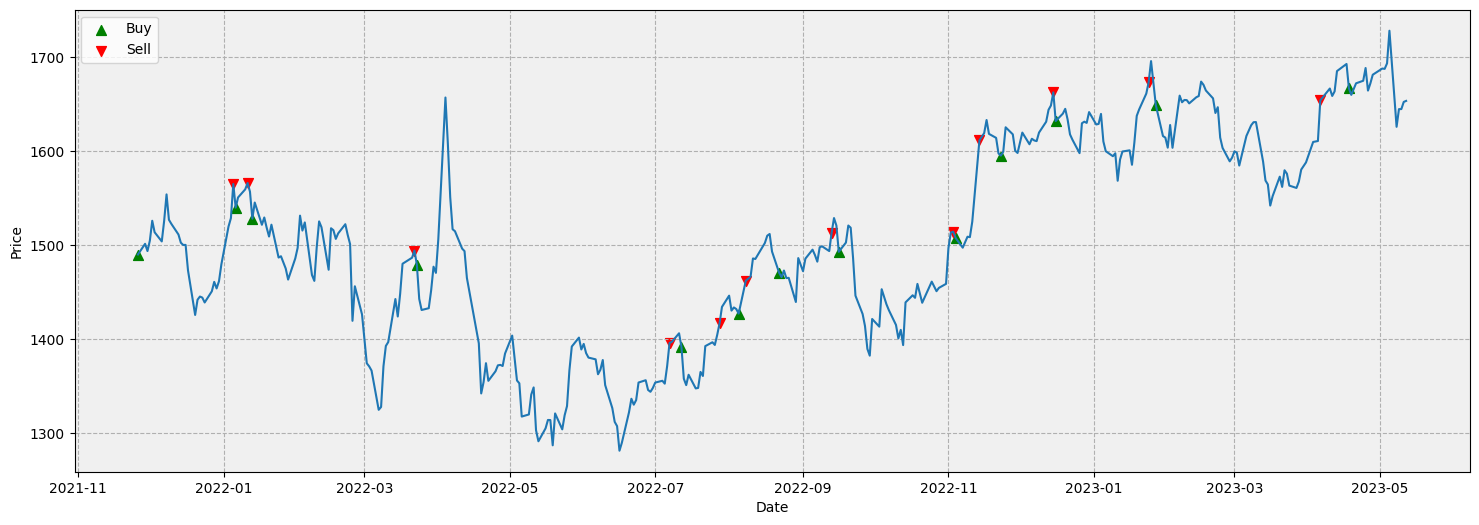

In [ ]:
predict_plot(data=hb, test=X_test, train=X_train, model=model, sensitivity=0.5)

In [ ]:
plot_regimes(hb, states=2)

Covariance matrix:  [array([[1241.99545907]]), array([[5218.99045953]])]
State with minimim covariance:  0
Number of observations for State  0 : 123
Number of observations for State  1 : 238


++++++++++++++++++++ TRADES USING HIDDEN MARKOV MODEL +++++++++++++++++++++++++++++++++
12/12 [==============================] - 0s 4ms/step
[0.05998394, 0.07920914, 0.078370824, 0.10319724, 0.14863682, 0.15717566, 0.1636052, 0.22191046, 0.33860323, 0.3207357, 0.3283871, 0.26379997, 0.21139738, 0.17401208, 0.1568172, 0.09500124, 0.072321914, 0.06773273, 0.06937722, 0.07238384, 0.071871616, 0.08239184, 0.09544127, 0.10238227, 0.12002267, 0.16964205, 0.30738834, 0.40675884, 0.5099195, 0.4777067, 0.49097902, 0.49430797, 0.5344162, 0.51449513, 0.43533555, 0.42543203, 0.3318314, 0.32371643, 0.258095, 0.19417468, 0.1820293, 0.1218353, 0.12851286, 0.1111345, 0.10142567, 0.11919721, 0.13904995, 0.24059759, 0.2612336, 0.33042213, 0.20804971, 0.16792378, 0.19324514, 0.27647457, 0.32971102, 0.24844342, 0.33652037, 0.31705812, 0.32063997, 0.33288494, 0.36958218, 0.3464074, 0.32154074, 0.15976606, 0.15827566, 0.094784535, 0.076749764, 0.061208628, 0.060118165, 0.052850552, 0.054459784, 0.0741255, 0

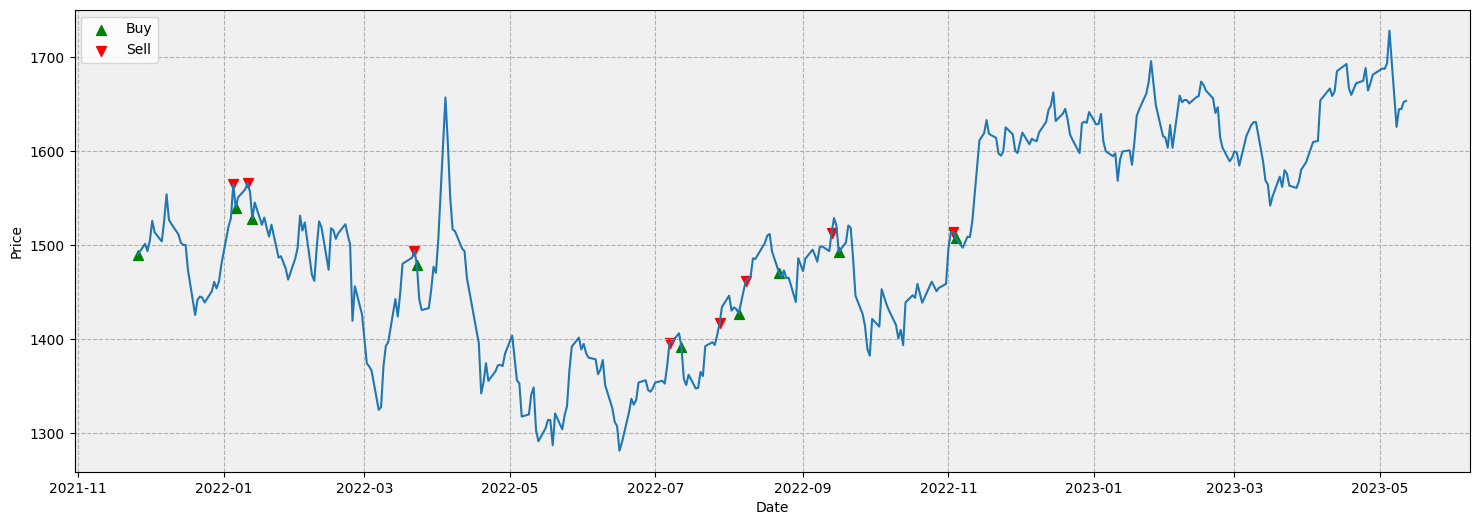

In [ ]:
predict_plot_with_hmm(data=hb, test=X_test, train=X_train, state_=1, model=model, sensitivity=0.5)

In [20]:
dx = get_data("DIXON.NS")
dx = add_ta_indicators(dx, 
                      sma_length=15, 
                      willr_length=14,
                      rsi_length=14,
                      macd_fast=12, macd_slow=26, macd_signal=9,
                      stoch_k=14, stoch_d=3, 
                      supertrend_length=14, supertrend_multiplier=3)

dx = add_trend(dx)
dx = add_signal_strength(dx)
X_train, X_test, y_train, y_test = normalize_split_data(dx)

model = train_model(X_train, y_train)

<ipython-input-13-30c7597758ee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["signal"] = np.where(con1, up, np.where(con2, down, 0))


Epoch 1/100
27/27 [==============================] - 24s 10ms/step - loss: 0.1429
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1391
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1378
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1359
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1337
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1316
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1299
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1283
Epoch 9/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1273
Epoch 10/100
27/27 [==============================] - 0s 10ms/step - loss: 0.1250
Epoch 11/100
27/27 [==============================] - 0s 11ms/step - loss: 0.1235
Epoch 12/100
27/27 [==============================] - 0s 14ms/step - loss: 0.1231
Epoch 13/100
27/27 [====

12/12 [==============================] - 1s 6ms/step
[0.55602634, 0.50559306, 0.40531364, 0.28632784, 0.324979, 0.28370312, 0.28108233, 0.28795606, 0.3700242, 0.40275854, 0.42359477, 0.4286326, 0.43595126, 0.4409831, 0.4277394, 0.33404693, 0.30354995, 0.20403011, 0.16982886, 0.13215572, 0.12080344, 0.11435843, 0.113214955, 0.16623303, 0.13811196, 0.15474786, 0.13241741, 0.110898376, 0.08615409, 0.08422291, 0.068162225, 0.0806131, 0.08487756, 0.09868941, 0.13273567, 0.13704386, 0.14265518, 0.1281433, 0.1146534, 0.13428546, 0.14762147, 0.14848357, 0.11061319, 0.1276351, 0.11814228, 0.11101331, 0.094897434, 0.09994431, 0.119969934, 0.16910662, 0.14407957, 0.30071643, 0.2981644, 0.34294793, 0.31968567, 0.27844492, 0.20921347, 0.1832456, 0.17095228, 0.18253298, 0.20350765, 0.31682903, 0.3465237, 0.46245447, 0.53474087, 0.59757215, 0.54315984, 0.5341135, 0.46441185, 0.41239744, 0.30087656, 0.27485034, 0.3194922, 0.31313285, 0.36887997, 0.41122597, 0.5244557, 0.54989856, 0.5104344, 0.48957905

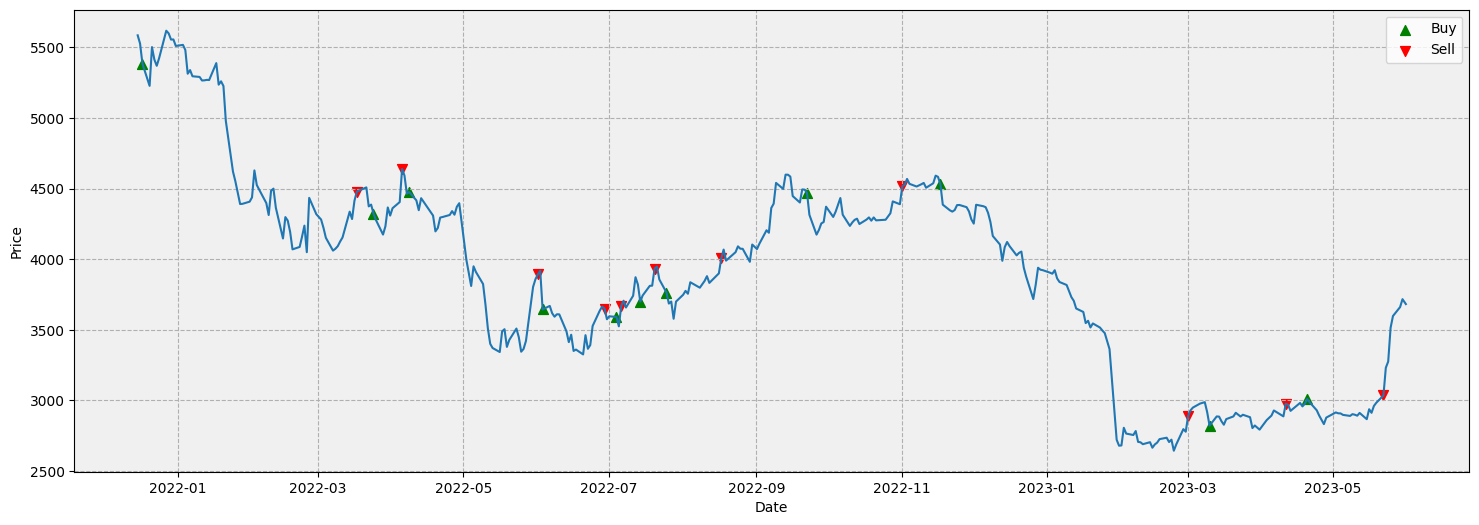

In [22]:
predict_plot(data=dx, test=X_test, train=X_train, model=model, sensitivity=0.5)

++++++++++++++++++++ TRADES USING HIDDEN MARKOV MODEL +++++++++++++++++++++++++++++++++
12/12 [==============================] - 0s 6ms/step
[0.55602634, 0.50559306, 0.40531364, 0.28632784, 0.324979, 0.28370312, 0.28108233, 0.28795606, 0.3700242, 0.40275854, 0.42359477, 0.4286326, 0.43595126, 0.4409831, 0.4277394, 0.33404693, 0.30354995, 0.20403011, 0.16982886, 0.13215572, 0.12080344, 0.11435843, 0.113214955, 0.16623303, 0.13811196, 0.15474786, 0.13241741, 0.110898376, 0.08615409, 0.08422291, 0.068162225, 0.0806131, 0.08487756, 0.09868941, 0.13273567, 0.13704386, 0.14265518, 0.1281433, 0.1146534, 0.13428546, 0.14762147, 0.14848357, 0.11061319, 0.1276351, 0.11814228, 0.11101331, 0.094897434, 0.09994431, 0.119969934, 0.16910662, 0.14407957, 0.30071643, 0.2981644, 0.34294793, 0.31968567, 0.27844492, 0.20921347, 0.1832456, 0.17095228, 0.18253298, 0.20350765, 0.31682903, 0.3465237, 0.46245447, 0.53474087, 0.59757215, 0.54315984, 0.5341135, 0.46441185, 0.41239744, 0.30087656, 0.27485034, 0.3

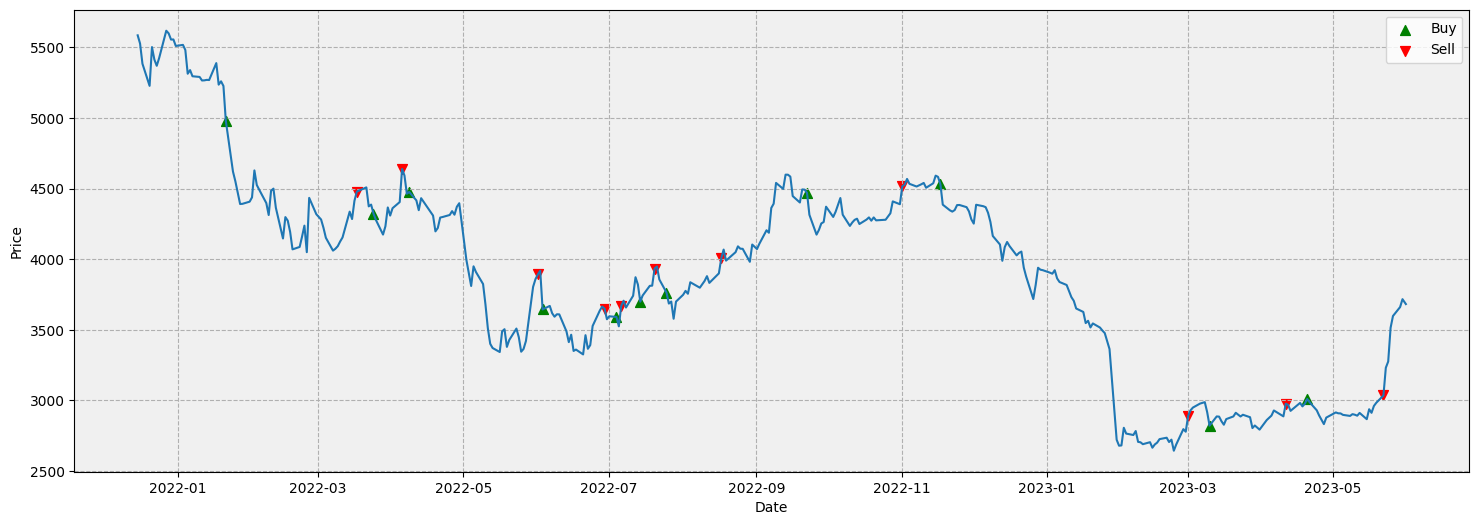

In [23]:
predict_plot_with_hmm(data=dx, test=X_test, train=X_train, state_=1, model=model, sensitivity=0.5)

In [27]:
plot_regimes(dx, states=4)

Covariance matrix:  [array([[293613.9911673]]), array([[267057.64339084]]), array([[187273.74072778]]), array([[16835.27218786]])]
State with minimim covariance:  3
Number of observations for State  0 : 16
Number of observations for State  1 : 18
Number of observations for State  2 : 186
Number of observations for State  3 : 141
